# Generating Primes

In [293]:
from sympy import primerange, isprime, nextprime, prime
import numpy as np
import matplotlib.pyplot as plt
from bisect import bisect, insort
import pandas as pd
from tqdm import tqdm

In [103]:
def get_n_primes(n:int # Number of primes
                     )->list: # List of first N primes
    "Get first 'n' primes."
    nth_prime = prime(n)
    return list(primerange(1,nth_prime+1))    

In [104]:
get_n_primes(10)

[2, 3, 5, 7, 11, 13, 17, 19, 23, 29]

In [254]:
def get_bit_vector(nums:list, # Positions of 1 else 0
                   size=None # Size of list
                  ):
    largest_n = nums[-1]
    if (size is None) or (size < largest_n):
        size = largest_n
    bit_vector = np.zeros(size)
    for i in nums:
        bit_vector[i-1] = 1
    return bit_vector

In [148]:
def convert_bit_vector_to_nums(vec:list):
    nums = []
    for i, v in enumerate(vec):
        if v == 1:
            nums += [i+1]
    return nums

In [149]:
convert_bit_vector_to_nums([0., 1., 1., 0., 1.])

[2, 3, 5]

In [125]:
def get_primes_bit_vector(n:int # Get bit vector of primes upto 'n'
                         ):
    primes = list(primerange(n+1))
    return primes, get_bit_vector(primes, n)

In [126]:
# Same as np.fft.fft()
def DFT(x):
    """
    Function to calculate the 
    discrete Fourier Transform 
    of a 1D real-valued signal x
    """

    N = len(x)
    n = np.arange(N)
    k = n.reshape((N, 1))
    e = np.exp(-2j * np.pi * k * n / N)
    
    X = np.dot(e, x)
    
    return X

In [236]:
class PrimePredictor:
    """
    Fourier Analysis of Primes and Predictions
    """

    def __init__(self, N):
        self.N = N # Fourier Ttansform on primes bit vector from [1,N]
        self.sr = N # Sampling rate
        self.T = self.N / self.sr
        self.freq = np.arange(self.N)/self.T
        self.primes, self.primes_bit_vector = get_primes_bit_vector(N)

        self.X = None
        
    def fft(self, plot=True):
        # print(f"N={len(self.primes_bit_vector)}")
        self.X = np.fft.fft(self.primes_bit_vector)
        # print(X)
        
        if plot:
            plt.figure(figsize = (8, 6))
            plt.stem(self.freq, np.abs(self.X), 'b', \
                     markerfmt=" ", basefmt="-b")
            plt.xlabel('Freq (Hz)')
            plt.ylabel('DFT Amplitude |X(freq)|')
            plt.show()

    def ifft(self, T:int):
        t = np.arange(T)
        probs = []
        for t in range(T):
            e = np.exp(2j*np.pi*self.freq*t/N)
            probs += [np.sum(np.dot(self.X, e)/N)]
        return np.round(np.abs(probs),2)

    def predictions(self, T, threshold=0.9, debug=True):
        probs = self.ifft(T)
        preds = (probs > threshold)*1.0
        pred_primes = convert_bit_vector_to_nums(preds)
        target_primes, target_bit_vector = get_primes_bit_vector(T)
        accu = sum(preds == target_bit_vector)/T
        if debug:
            print(f"Accuracy={accu}")
            print(f"Target Primes={target_primes}")
            print(f"Preds  Primes={pred_primes}")
        return accu, target_primes, pred_primes, probs

    def metrics(self, T, target_primes, pred_primes, debug=True):
        new_target_primes = target_primes[bisect(target_primes, self.N):]
        new_target_primes_set = set(new_target_primes)
        num_new_primes = len(new_target_primes)
        
        new_pred_primes = pred_primes[bisect(pred_primes, self.N):]
        num_pred_primes = len(new_pred_primes)
        new_pred_primes_set = set(new_pred_primes)
        correct_pred_primes = new_target_primes_set.intersection(new_pred_primes_set)

        primes_recall = len(correct_pred_primes)
        recall = primes_recall/num_new_primes
        precision = primes_recall/num_pred_primes
        f_score =  2*recall*precision/(recall+precision)
        if debug:
            # print (new_target_primes)
            # print(new_pred_primes)
            print(f"Number of new primes: {num_new_primes}")
            print(f"Number of pred primes: {num_pred_primes}")
            print(f"Primes recalled: {primes_recall}, recall: {recall:0.3f}")
            print(f"Precision of primes: {precision:0.3f}")
            print(f"f_score: {f_score:.3f}")
        return recall, precision, f_score

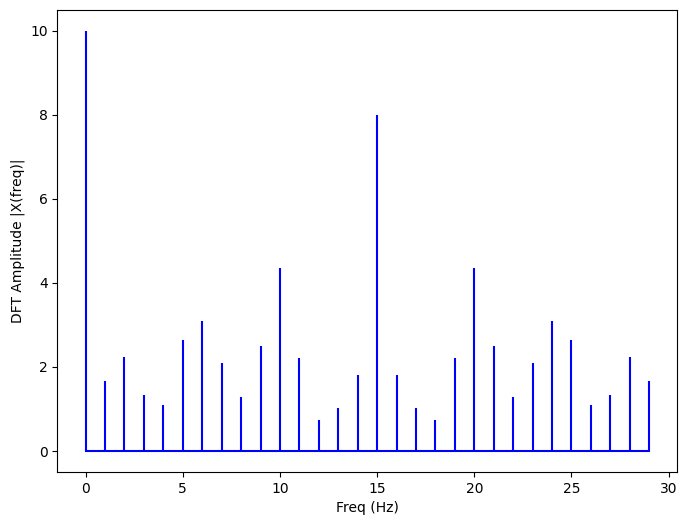

Number of new primes: 9582
Number of pred primes: 33324
Primes recalled: 8393, recall: 0.876
Precision of primes: 0.252
f_score: 0.391


(0.8759131705280735, 0.25186052094586486, 0.3912273341723768)

In [237]:
prime_predictor = PrimePredictor(30)
prime_predictor.fft()
# prime_predictor.ifft(30)
T = 100000
accu, target_primes, pred_primes, probs = prime_predictor.predictions(T, debug=False)
prime_predictor.metrics(T, target_primes, pred_primes)

In [294]:
# Mersenne Prime Predictor

class MersennePrimePredictor:
    """
    Fourier Analysis of Primes and Predictions
    """

    def __init__(self, M):
        mersenne_primes_df = pd.read_csv("./data/Mersenne_Primes.csv")
        self.exponents = mersenne_primes_df["Exponent"].to_list()
        self.M = M # Number of Mersenne exponents for FT
        self.primes = self.exponents[:self.M]
        self.primes_bit_vector = get_bit_vector(self.primes)
        self.N = self.primes[-1]
        
        self.sr = N # Sampling rate
        self.T = self.N / self.sr
        self.freq = np.arange(self.N)/self.T

        self.X = None
        
    def fft(self, plot=True):
        # print(f"N={len(self.primes_bit_vector)}")
        self.X = np.fft.fft(self.primes_bit_vector)
        # print(X)
        
        if plot:
            plt.figure(figsize = (8, 6))
            plt.stem(self.freq, np.abs(self.X), 'b', \
                     markerfmt=" ", basefmt="-b")
            plt.xlabel('Freq (Hz)')
            plt.ylabel('DFT Amplitude |X(freq)|')
            plt.show()

    def ifft(self, T:int):
        t = np.arange(T)
        probs = []
        for t in tqdm(range(T)):
            e = np.exp(2j*np.pi*self.freq*t/N)
            probs += [np.sum(np.dot(self.X, e)/N)]
        return np.round(np.abs(probs),2)

    def predictions(self, T, threshold=0.9, debug=True):
        probs = self.ifft(T)
        preds = (probs > threshold)*1.0
        pred_primes = convert_bit_vector_to_nums(preds)
        target_primes = [p for p in self.exponents if p <= T]
        target_bit_vector = get_bit_vector(target_primes)
        
        accu = sum(preds == target_bit_vector)/T
        if debug:
            print(f"Accuracy={accu}")
            print(f"Target Primes={target_primes}")
            print(f"Preds  Primes={pred_primes}")
        return accu, target_primes, pred_primes, probs

    def metrics(self, T, target_primes, pred_primes, debug=True):
        new_target_primes = target_primes[bisect(target_primes, self.N):]
        new_target_primes_set = set(new_target_primes)
        num_new_primes = len(new_target_primes)
        
        new_pred_primes = pred_primes[bisect(pred_primes, self.N):]
        num_pred_primes = len(new_pred_primes)
        new_pred_primes_set = set(new_pred_primes)
        correct_pred_primes = new_target_primes_set.intersection(new_pred_primes_set)

        primes_recall = len(correct_pred_primes)
        recall = primes_recall/num_new_primes
        precision = primes_recall/num_pred_primes
        f_score =  2*recall*precision/(recall+precision)
        if debug:
            # print(new_target_primes)
            # print(new_pred_primes)
            print(f"Number of new primes: {num_new_primes}")
            print(f"Number of pred primes: {num_pred_primes}")
            print(f"Primes recalled: {primes_recall}, recall: {recall:0.3f}")
            print(f"Precision of primes: {precision:0.3f}")
            print(f"f_score: {f_score:.3f}")
        return recall, precision, f_score

In [295]:
mersenne_primes_df = pd.read_csv("./data/Mersenne_Primes.csv")
mersenne_primes_df.head(50)

,No,Exponent
0,1,2
1,2,3
2,3,5
3,4,7
4,5,13
5,6,17
6,7,19
7,8,31
8,9,61
9,10,89


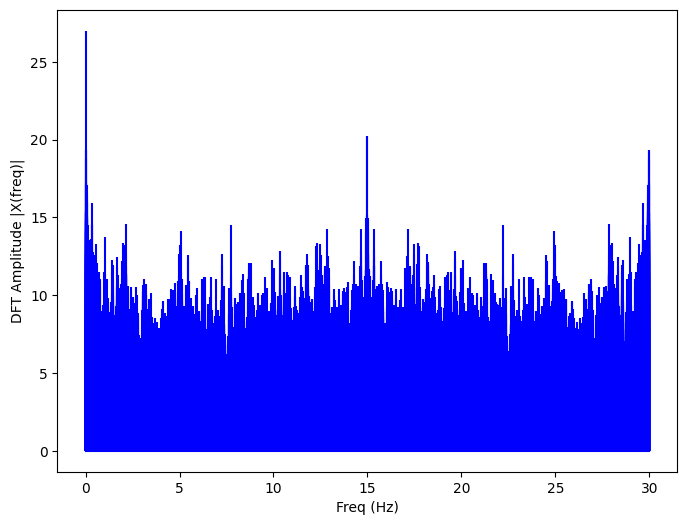

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 132049/132049 [01:14<00:00, 1780.83it/s]

Accuracy=0.9995759150012495
Target Primes=[2, 3, 5, 7, 13, 17, 19, 31, 61, 89, 107, 127, 521, 607, 1279, 2203, 2281, 3217, 4253, 4423, 9689, 9941, 11213, 19937, 21701, 23209, 44497, 86243, 110503, 132049]
Preds  Primes=[2, 3, 5, 7, 13, 17, 19, 31, 61, 89, 107, 127, 521, 607, 1279, 2203, 2281, 3217, 4253, 4423, 9689, 9941, 11213, 19937, 21701, 23209, 44497, 44499, 44500, 44502, 44504, 44510, 44514, 44516, 44528, 44558, 44586, 44604, 44624, 45018, 45104, 45776, 46700, 46778, 47714, 48750, 48920, 54186, 54438, 55710, 64434, 66198, 67706, 88994, 88996, 88997, 88999, 89001, 89007, 89011, 89013, 89025, 89055, 89083, 89101, 89121, 89515, 89601, 90273, 91197, 91275, 92211, 93247, 93417, 98683, 98935, 100207, 108931, 110695, 112203]


ZeroDivisionError: float division by zero

In [296]:
mersenne_prime_predictor = MersennePrimePredictor(27)
mersenne_prime_predictor.fft()
T = 132049
accu, target_primes, pred_primes, probs = mersenne_prime_predictor.predictions(T, debug=True)
mersenne_prime_predictor.metrics(T, target_primes, pred_primes)